# Bayesian Computational Imaging with Pyxu

In this guide we will walk you through how to use Pyxu to solve a MAP estimation problem from a Bayesian definition of
an inverse problem. We will go step by step, relating text, equations, and code to provide a clear understanding of the
process.

## Understanding the Problem

From a Bayesian perspective, an inverse problem can be formulated as finding the most credible image $\hat{\mathbf{x}}$
given the measured (degraded) image $\mathbf{y}$, the model of the measurement (a.k.a. the forward model) $\mathbf{F}$,
and a prior probability over the distribution of $\mathbf{x}$. In this scenario, we are trying to find the best possible
original image ($\mathbf{x}$) given the degraded image we have ($\mathbf{y}$). This is known as the *maximum a
posteriori estimate (MAP)*, defined by the equation:

$$\hat{\mathbf{x}}_{MAP} = \arg \max_{\mathbf{x}} p(\mathbf{x} | \mathbf{y}) = \arg \max_{\mathbf{x}}
\frac{p(\mathbf{y}|\mathbf{x}) p(\mathbf{x})}{p(\mathbf{y})},$$

where:
- $p(\mathbf{x}|\mathbf{y})$ is the *posterior probability*: It gives us a measure of how probable a specific version of
  the original image $\mathbf{x}$ is, given the degraded image we are observing $\mathbf{y}$. Essentially, it helps us
  estimate the most credible original image considering the information we have from the degraded image.
- $p(\mathbf{y}|\mathbf{x})$ is the *likelihood function*: In the process of image degradation, various forms of noise
  such as salt-and-pepper or Gaussian noise can be introduced, altering the original image $\mathbf{x}$ and resulting in
  a degraded version $\mathbf{y}$. The noise model is essentially a mathematical representation of how this noise
  affects the image. The likelihood function models how likely we are to observe the degraded image ($\mathbf{y}$) given
  a specific version of the original image ($\mathbf{x}$) and the noise model.  
- $p(\mathbf{x})$ defines the *prior*, our initial belief or assumption about the original image $\mathbf{x}$ before we
  even look at the degraded image $\mathbf{y}$. For instance, we might assume that the image has smooth regions, sharp
  edges, or certain statistical properties.
- $p(\mathbf{y})$: This term represents the probability of observing the degraded image $\mathbf{y}$ without considering
  any information about the original image $\mathbf{x}$. In the context of finding the most probable original image,
  this term does not provide any useful information because it is not influenced by the original image ($\mathbf{x}$).
  Therefore, it does not help in improving our estimate of the original image and can be safely ignored during the
  reconstruction process.

## Simplifying the Optimization Problem

To simplify the optimization problem, we take the negative log-transform of the posterior distribution, allowing us to
minimize over a sum instead of maximizing over a product: 

$$\hat{\mathbf{x}}_{MAP} = \arg \max_{\mathbf{x}} p(\mathbf{x} | \mathbf{y}) = \arg \min_{\mathbf{x}} \left\{ - \log
p(\mathbf{x} | \mathbf{y}) \right\} = \arg \min_{\mathbf{x}} \left\{- \log p(\mathbf{y}|\mathbf{x})  - \log
p(\mathbf{x})\right\}.$$
    
## Defining the Likelihood Function

The likelihood function defines how likely a measurement $\mathbf{y}$ is given a particular scene $\mathbf{x}$, so it
basically models the acquisition process. Imagine that we can model our measurement $\mathbf{y}$ as the application of a
linear operator $\mathbf{F}$ on the scene of interest $\mathbf{x}$, i.e., $\mathbf{y} = \mathbf{F}\mathbf{x}$. (See also
the user guide on [Forward Operators](./fwdops.html).) In every application, there is measurement noise in our sensors,
and commonly we assume that it follows a Gaussian distribution. In that case, the likelihood function can also be
defined by a Gaussian distribution with the same mean and variance as the noise. In this case, the likelihood function
is defined as:

$$p(\mathbf{y} | \mathbf{x} )= \prod_{i=0}^{M-1} \frac{1}{\sigma\sqrt{2\pi}} \exp \left\{- \frac{1}{2\sigma^{2}}
\left(y_{i} - \langle \mathbf{F}_{i}, \mathbf{x} \rangle \right)^{2}  \right\},$$

where $\sigma_{i} = \sigma$ and $\mu_{i} = \langle \mathbf{F}_{i}, \mathbf{x} \rangle$ define the standard deviation and
mean of the Gaussian distribution at each sensor. Applying the negative log-transform, results in a quadratic term plus
a constant term $M \log(2\pi \sigma)$. Ignoring the latter as it does not affect the optimized variable $\mathbf{x}$, we
obtain the well-known least-squares form: $$- \log p(\mathbf{y} | \mathbf{x} )= \frac{1}{2\sigma^{2}} \Vert \mathbf{y} -
\mathbf{F}\mathbf{x} \Vert^{2}_{2}. $$

For other cost functionals, see the following Table, and take a look at the user guide on [Loss & Regularization
functionals](./funcs.html). 

### Table 1: Choice of cost functional based on noise modeling

|     Noise Type      |                                           Likelihood $p(\mathbf{y}\vert\mathbf{x})$                                           |   Cost Functional $F(\mathbf{y}, \mathbf{G}\mathbf{x}) = - \log p(\mathbf{y}\vert\mathbf{x})$   |
|:-------------------:|:-----------------------------------------------------------------------------------------------------------------------------:|:-----------------------------------------------------------------------------------------------:|
| **Gaussian Noise**  | $\frac{1}{\sqrt{2 \pi \sigma^2}} \exp \left(-\frac{1}{2\sigma^2} \Vert\mathbf{y} - \mathbf{G}\mathbf{x}\Vert_{2}^{2} \right)$ |                      $\Vert\mathbf{y} - \mathbf{G}\mathbf{x}\Vert_{2}^{2}$                      |
| **Laplacian Noise** |             $\frac{1}{2\sigma}\exp \left( -\frac{\Vert \mathbf{y} - \mathbf{G}\mathbf{x}\Vert_1}{\sigma} \right)$             |                       $\Vert\mathbf{y} - \mathbf{G}\mathbf{x} \Vert_{1}$                        |
|  **Poisson Noise**  |                                  $\frac{e^{-\lambda(\mathbf{x})} \lambda(\mathbf{x})^y}{y!}$                                  | $-\sum_{i} \left( y_i \log(\lambda_i(\mathbf{x})) - \lambda_i(\mathbf{x}) - \log(y_i!) \right)$ |


## Defining the Prior Distribution

The prior distribution in general defines our assumptions of the unknown scene $\mathbf{x}$, in order to favour
solutions that fullfill those assumptions in our reconstructed scene $\hat{\mathbf{x}}$. One common assumption is total
variation (TV), in which we assume that the scene is kind of piece-wise constant. This is equivalent as saying that its
gradient has only a few peaks, or large values, and is well modeled by the Laplacian probability distribution on the
gradient coefficients $\mathbf{D}\mathbf{x}$:

$$p(\mathbf{x}) = \prod_{i=0}^{N-1}\frac{1}{2\beta}  \exp \left\{ - \frac{|\mathbf{D}(\mathbf{x})_{i} |}{\beta}
\right\},$$

where $\beta$ is the [scale parameter](https://en.wikipedia.org/wiki/Scale_parameter), related to the standard
deviation. After applying the negative log-transform and ignoring the constant term, results in the $\ell_ {1}$-norm: 
$$- \log p(\mathbf{x}) = \frac{1}{\beta} \Vert \mathbf{D}\mathbf{x}\Vert_{1}.$$


For other regularization functionals, see the following Table, and take a look at the user guide on [Loss &
Regularization functionals](./funcs.html).

### Table 2: Choice of regularization functional based on the prior distribution

|   Regularization Type    |                            Prior distribution  $p (\mathbf{x})$                            |  Regularising Functional $R(\mathbf{x}) = -\log p(\mathbf{x})$  |
|:------------------------:|:------------------------------------------------------------------------------------------:|:---------------------------------------------------------------:|
|       **Tikhonov**       |  $p (\mathbf{x}) \propto \exp \left( - \Vert \mathbf{x}            \Vert_{2}^{2} \right)$  |                  $\Vert \mathbf{x} \Vert_{2}^{2}$                   |
| **Generalised Tikhonov** |  $p (\mathbf{x}) \propto \exp \left( - \Vert \mathbf{D} \mathbf{x} \Vert_{2}^{2} \right)$  |             $\Vert \mathbf{D}\mathbf{x} \Vert_{2}^{2}$              |
|        $\ell_{1}$        |    $p (\mathbf{x}) \propto \exp \left( - \Vert \mathbf{x}            \Vert_{1} \right)$    |                   $\Vert \mathbf{x}\Vert_{1}$                   |
|   **Total Variation**    |    $p (\mathbf{x}) \propto \exp \left( - \Vert \mathbf{D} \mathbf{x} \Vert_{1} \right)$    |             $\Vert \mathbf{D} \mathbf{x} \Vert_{1}$             |



## Combining the Likelihood and Prior

Combining the likelihood and prior, we can rewrite the optimization problem as: 
$$\hat{\mathbf{x}}_{MAP} = \arg \min_{\mathbf{x}} \frac{1}{2\sigma^{2}} \Vert \mathbf{y} - \mathbf{F}\mathbf{x}
\Vert^{2}_{2} + \frac{1}{\beta} \Vert \mathbf{D} \mathbf{x}\Vert_{1}. $$

We can also rewrite the above equation, without changing the value of the minimizer, as:

$$\hat{\mathbf{x}}_{MAP} = \arg \min_{\mathbf{x}} \Vert \mathbf{y} - \mathbf{F}\mathbf{x} \Vert^{2}_{2} +
\frac{2\sigma^{2}}{\beta} \Vert \mathbf{D}\mathbf{x}\Vert_{1}. $$

We can now define $\lambda = \frac{2\sigma^{2}}{\beta}$ as the uncertainty trade-off between the likelihood and the
prior, yielding our simplified *MAP estimator*:

$$\hat{\mathbf{x}}_{MAP} = \arg \min_{\mathbf{x}} \Vert \mathbf{y} - \mathbf{F}\mathbf{x} \Vert^{2}_{2} + \lambda \Vert
\mathbf{D} \mathbf{x}\Vert_{1}.$$

# Implementing with Pyxu

Now, we will implement the above formulation using Pyxu. 

In this example, we will explore a practical application of the Maximum a Posteriori (MAP) approach to solve the problem
of image denoising. The forward model in this case is an identity operator, meaning that we are directly observing the
noisy image without any underlying model of transformation. As a prior, we will incorporate a total variation prior and
a positivity constraint to improve the quality of the denoised image.

## First, import the necessary modules:


In [12]:
# Importing necessary libraries and modules
import matplotlib.pyplot as plt
import numpy as np

from pyxu.operator import L21Norm, Gradient, SquaredL2Norm, PositiveOrthant, IdentityOp
from pyxu.opt.solver import PD3O
from pyxu.opt.stop import RelError
from PIL import Image


## Loading and Preprocessing the Image

We load a sample image and preprocess it to be suitable for the denoising process. The image is converted to a float
type and normalized to have pixel values between 0 and 1.

In [13]:
# Loading and preprocessing the image
data = Image.open("../_static/favicon.png").convert("L")
data = (np.asarray(data).astype("float32") / 255.0)[::4, ::4]


## Adding Noise to the Image

We add Gaussian noise to the image to simulate a real-world noisy observation. The identity operator is used as the
forward model, indicating that the observed image is directly the noisy image.

In [14]:
# Adding noise to the image using the identity operator
id_op = IdentityOp(dim=data.size)

sigma = 0.05  # Standard deviation of the Gaussian noise
y = id_op(data.ravel()).reshape(data.shape)
y = np.random.normal(y, sigma)  # Adding noise
y = y.clip(0, 1)  # Clipping to maintain pixel values between 0 and 1


## MAP Approach with Total Variation Prior and Positivity Constraint

We set up the MAP approach to denoise the image. The total variation prior is used to promote piecewise smooth
solutions, and the positivity constraint ensures non-negative pixel values. The optimization problem is formulated as:

$$\hat{\mathbf{x}}_{\text{MAP}}=\arg\min_{\mathbf{x} ≥ \mathbf{0}}\Vert
\mathbf{y}−\mathbf{x}\Vert^{2}_{2}+\lambda\Vert\nabla\mathbf{x}\Vert_{1},$$

where:

- $\Vert \mathbf{y}−\mathbf{x}\Vert_{2}^{2}$ is the squared L2 norm corresponding to the (scaled) log-likelihood of the
  data,
- $\Vert\nabla\mathbf{x}\Vert_{1}$ is the L21 norm representing the total variation prior,
- $\lambda$ is the regularization parameter balancing the two terms,
- $\mathbf{x}≥\mathbf{0}$ is the positivity constraint ensuring non-negative pixel values.

In [15]:
# Setting up the MAP approach with total variation prior and positivity constraint
sl2 = SquaredL2Norm(dim=y.size).asloss(y.ravel())
loss = sl2 * id_op  # Data fidelity term

beta = 0.025  # Parameter related to the noise level
lambda_ = (2 * sigma ** 2) / beta  # Regularization parameter

l21 = L21Norm(arg_shape=(2, *y.shape), l2_axis=(0, ))  # Total variation prior
grad = Gradient(
    arg_shape=y.shape,
    diff_method="fd",
    scheme="central",
    accuracy=8,
)  # Gradient operator

stop_crit = RelError(
    eps=1e-5,
    var="x",
    f=None,
    norm=2,
    satisfy_all=True,
)

positivity = PositiveOrthant(dim=y.size)  # Positivity constraint
solver = PD3O(f=loss, g=positivity, h=lambda_ * l21, K=grad, show_progress=False)
solver.fit(x0=y.ravel(), stop_crit=stop_crit)  # Solving the optimization problem


## Obtaining and Visualizing the Denoised Image

We retrieve the denoised image from the solver and normalize it. We then visualize the original image, the noisy image,
and the denoised image side by side for comparison.

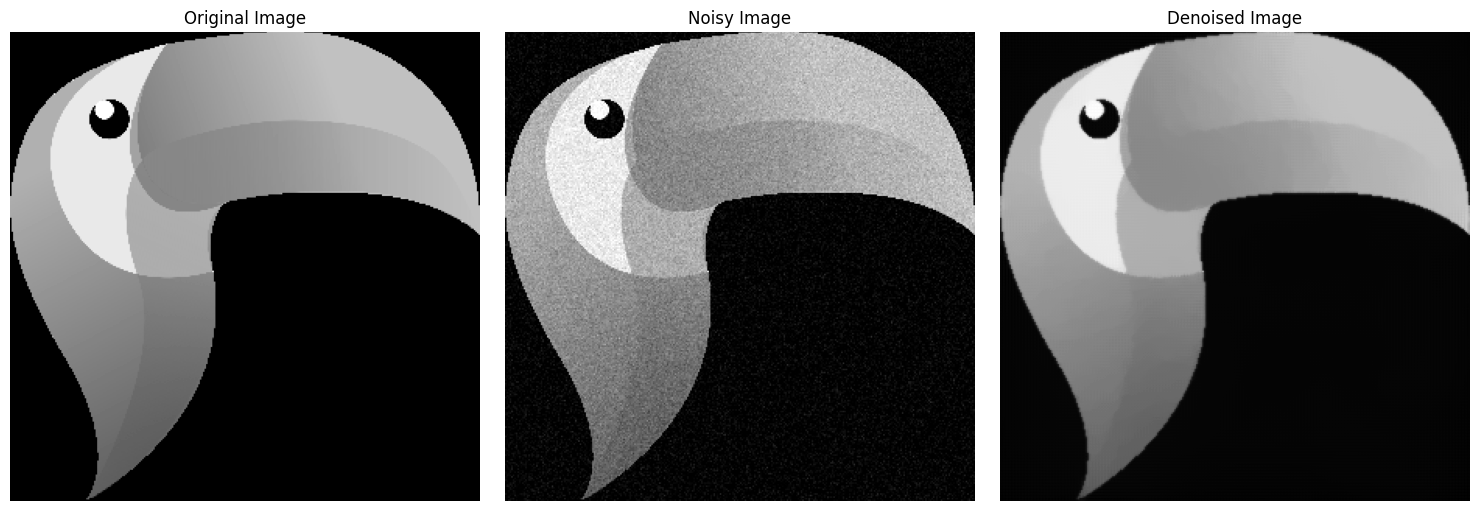

In [16]:
# Obtaining the denoised image
recons = solver.solution().reshape(y.shape)
recons = recons.clip(0, 1)  # clipping to maintain pixel values between 0 and 1

# Visualizing the images
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].imshow(data, cmap='gray')
axs[0].set_title("Original Image")
axs[0].axis('off')

axs[1].imshow(y, cmap='gray')
axs[1].set_title("Noisy Image")
axs[1].axis('off')

axs[2].imshow(recons, cmap='gray')
axs[2].set_title("Denoised Image")
axs[2].axis('off')

plt.tight_layout()
plt.show()


In this final visualization, the original, noisy, and denoised images are displayed for a comprehensive comparison,
showcasing the effectiveness of the MAP approach with a total variation prior and positivity constraint in image
denoising.